<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
# Импорт библиотек
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.metrics import f1_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
# Загрузка данных
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 10000 entries, 0 to 9999

Data columns (total 14 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   RowNumber        10000 non-null  int64  

 1   CustomerId       10000 non-null  int64  

 2   Surname          10000 non-null  object 

 3   CreditScore      10000 non-null  int64  

 4   Geography        10000 non-null  object 

 5   Gender           10000 non-null  object 

 6   Age              10000 non-null  int64  

 7   Tenure           9091 non-null   float64

 8   Balance          10000 non-null  float64

 9   NumOfProducts    10000 non-null  int64  

 10  HasCrCard        10000 non-null  int64  

 11  IsActiveMember   10000 non-null  int64  

 12  EstimatedSalary  10000 non-null  float64

 13  Exited           10000 non-null  int64  

dtypes: float64(3), int64(8), object(3)

memory usage: 1.1+ MB


In [4]:
#Проверка данных на наличие явных строк-дубликатов
if data.duplicated().sum() == 0:
    print('В данных нет строк с явными дубликатами.')
else:
    print('В данных имеются строки дубликаты в количестве:', data.duplicated().sum())

В данных нет строк с явными дубликатами.


**Вывод:** есть 10000 строк данных, при этом столбец "RowNumber" выполняет функцию индекса. В данных нет строк с явными дубликатами. Пропуски находятся в столбце "Tenure" и составляют около 10%. Будем считать, что это новые клиенты и заполним пропуски 0.

In [5]:
data.loc[data['Tenure'].isna(), 'Tenure'] = 0

Столбцы "CustomerId" и "Surname" являются способом идентификации клиента и не будут признаками при прогнозировании. Столбцы  "Geography" и "Gender" являются категориальными признаками, преобразуем их в численные с помощью техники прямого кодирования.

In [6]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


## Исследование задачи

Проверим дисбаланс классов.

In [7]:
print(data['Exited'].sum())

2037


Из 9091 записей 2037 относятся к классу "1", а остальные к классу "0". 

Разделим данные на обучающую и валидационную выборки и осуществим стандартизацию признаков.

In [8]:
target = data['Exited']
features = data_ohe.drop('Exited', axis=1)

In [9]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [10]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric]  = scaler.transform(features_valid[numeric])
features_test[numeric]  = scaler.transform(features_test[numeric])

/tmp/ipykernel_86/4029355310.py:5: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  features_train[numeric] = scaler.transform(features_train[numeric])

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [11]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.33389544688026984


In [12]:
#Обучим модель леса решающих деревьев
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.5786350148367952


In [13]:
max_f1 = 0
for dept in range(2, 15):
    for nest in range(10, 100, 10):
        model = RandomForestClassifier(n_estimators=nest, max_depth=dept, random_state=12345)
        model.fit(features_train, target_train)
        
        if f1_score(target_valid, model.predict(features_valid)) > max_f1:
            max_f1 = f1_score(target_valid, model.predict(features_valid))
            best_model = model
            
print('f1_score =', max_f1)

f1_score = 0.5945945945945945


**Вывод:** значение метрики f1 для решающего леса чуть больше половины, при дисбалансе классов в 4 раза. Устранение дисбаланса может улучшить результат предсказания модели.

## Борьба с дисбалансом

Исправим дисбаланс классов при помощи увеличения выборки копированием строк малочисленного класса.

In [14]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [15]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Обучим несколько моделей и осуществимподбор оптимальных парааметров для лучшей.

In [16]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.4575645756457565


In [17]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.5992010652463382


In [18]:
model = LogisticRegression(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.4888888888888888


In [19]:
max_f1 = 0
for dept in range(2, 15):
    for nest in range(10, 100, 10):
        model = RandomForestClassifier(n_estimators=nest, max_depth=dept, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        
        if f1_score(target_valid, model.predict(features_valid)) > max_f1:
            max_f1 = f1_score(target_valid, model.predict(features_valid))
            best_model1 = model
            
print('f1_score =', max_f1)

f1_score = 0.626829268292683


Исправим дисбаланс классов при помощи взвешивания классов.

In [20]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.45622688039457454


In [21]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.5609756097560976


In [22]:
model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.4888888888888888


In [23]:
max_f1 = 0
for dept in range(2, 15):
    for nest in range(10, 100, 10):
        model = RandomForestClassifier(n_estimators=nest, max_depth=dept, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        
        if f1_score(target_valid, model.predict(features_valid)) > max_f1:
            max_f1 = f1_score(target_valid, model.predict(features_valid))
            best_model2 = model
            
print('f1_score =', max_f1)

f1_score = 0.631236442516269


In [24]:
probabilities_valid = best_model1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid, probabilities_one_valid)

0.8448083704837314

In [25]:
probabilities_valid = best_model2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid, probabilities_one_valid)

0.8544722627163244

**Вывод:** случайный лес оказался наиболее точным классификатором. По сравнению с результатом полученным до баланса классов значение метрики f1 улучшилось. Результат полученный при взвешивании классов лучше, чем при расширении выборки, имеет смысл провести тестирование для обеих моделей.

## Тестирование модели

In [26]:
predicted_test = best_model1.predict(features_test)
f1_score(target_test, predicted_test)

0.6115107913669066

In [27]:
predicted_test = best_model2.predict(features_test)
f1_score(target_test, predicted_test)

0.6079484425349088

In [28]:
probabilities_test = best_model1.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

roc_auc_score(target_test, probabilities_one_test)

0.8535118450659676

**Вывод:** для классификации отброшены ненужные столбцы данных, преобразованы техникой прямого кодирования, построена модель случайного леса, осуществлен перебор параметров. Достигнуто значение метрики f1 в 0.61 для тестовых данных, значения метрики AUC-ROC равно 0.85. Для тестовых данных модель обученная с расширением данных показала немного лучший результат.

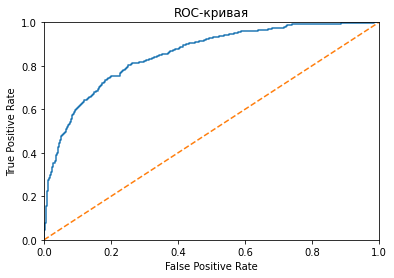

In [29]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.show()